In [1]:
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable

import os
import glob
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import librosa # librosa: Audio handling package
import random
import copy
import re
import jamotools

from tqdm import tqdm_notebook as tqdm # tqdm: Pakage for progress bar visualization
from datetime import datetime

import threading
import queue

import Levenshtein as Lev

In [2]:
n_mels = 256
fs = 16000
frame_length_ms=50
frame_shift_ms=25
nsc = int(fs * frame_length_ms / 1000)
nov = nsc - int(fs * frame_shift_ms / 1000)
nhop = int(fs * frame_shift_ms / 1000)
eps = 1e-8
db_ref = 160

# n_mels = 256

print('n_mels is now {}'.format(n_mels))

# meta_path = 'gdrive/My Drive/korean-single-speaker-speech-dataset/transcript.v.1.2.txt'
# data_folder = 'gdrive/My Drive/korean-single-speaker-speech-dataset/kss'

# meta_path = "D:/korean-single-speaker-speech-dataset/transcript.v.1.2.txt"
# data_folder = "D:/korean-single-speaker-speech-dataset/kss"

data_folder = "D:/nsml-dataset/train_data/"
label_path = "D:/nsml-dataset/hackathon.labels"

data_list = glob.glob(data_folder + '*.csv')[0]

wav_paths = list()
script_paths = list()
korean_script_paths = list()

with open(data_list, 'r') as f:
    for line in f:
        # line: "aaa.wav,aaa.label"
        wav_path, script_path = line.strip().split(',')
        korean_script_path = script_path.replace('.label', '.script')
        
        wav_paths.append(os.path.join(data_folder, wav_path))
        script_paths.append(os.path.join(data_folder, script_path))
        korean_script_paths.append(os.path.join(data_folder, korean_script_path))

dataset_size = len(wav_paths)

n_mels is now 256


In [3]:
def get_label(filepath, bos_id, eos_id):
    key = filepath.split('/')[-1].split('.')[0]
    script = target_dict[key]
    tokens = script.split(' ')
    result = list()
    result.append(bos_id)
    for i in range(len(tokens)):
        if len(tokens[i]) > 0:
            result.append(int(tokens[i]))
    result.append(eos_id)
    return result

In [4]:
print("wav_paths len: {}".format(len(wav_paths)))
print("script_paths len: {}".format(len(script_paths)))
print("korean_script_paths len: {}".format(len(korean_script_paths)))

print(wav_paths[0])
print(script_paths[0])
print(korean_script_paths[0])

wav_paths len: 29805
script_paths len: 29805
korean_script_paths len: 29805
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.wav
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.label
D:/nsml-dataset/train_data/41_0601_211_0_07930_02.script


In [5]:
with open(script_paths[1]) as f:
    line = f.read()
    line = line.strip()
    result = list(map(int, line.split(' ')))

In [6]:
def load_label(label_path):
    char2index = dict() # [ch] = id
    index2char = dict() # [id] = ch
    with open(label_path, 'r', encoding='UTF-8') as f:
    # with open(label_path, 'r') as f:
        for no, line in enumerate(f):
            if line[0] == '#': 
                continue

            index, char, freq = line.strip().split('\t')
            char = char.strip()
            if len(char) == 0:
                char = ' '

            char2index[char] = int(index)
            index2char[int(index)] = char

    return char2index, index2char

In [7]:
char2index, index2char = load_label(label_path)
SOS_token = char2index['<s>']  # '<sos>' or '<s>'
EOS_token = char2index['</s>']  # '<eos>' or '</s>'
PAD_token = char2index['_']  # '-' or '_'

In [8]:
korean_script_list = list()
jamo_script_list = list()

jamo_regex = re.compile(u'[,_ ^.?!？~<>:;/%()+A-Za-z0-9\u1100-\u115e\u1161-\u11A7\u11a8-\u11ff]+')

for file in tqdm(korean_script_paths):
    with open(file, 'r', encoding='utf-8') as f:
        line = f.read()
        line = line.strip()
        korean_script_list.append(line)
        jamo = jamotools.split_syllables(line, 'JAMO')
        jamo_filtered = ''.join(jamo_regex.findall(jamo))
        jamo_script_list.append(jamo_filtered)

In [9]:
class Threading_Batched_Preloader():
    def __init__(self, wav_path_list, ground_truth_list, script_path_list, batch_size, is_train=True):
        super(Threading_Batched_Preloader).__init__()
        self.wav_path_list = wav_path_list
        self.total_num_input = len(wav_path_list)
        self.tensor_input_list = [None] * self.total_num_input
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.sentence_length_list = np.asarray(list(map(len, ground_truth_list)))
        self.shuffle_step = 12
        self.loading_sequence = None
        self.end_flag = False
        self.batch_size = batch_size
        self.queue = queue.Queue(32)
        self.thread_flags = list()
        self.is_train = is_train
    
    # Shuffle loading index and set end flag to false
    def initialize_batch(self, thread_num):
        loading_sequence = np.argsort(self.sentence_length_list)
        bundle = np.stack([self.sentence_length_list[loading_sequence], loading_sequence])

        for seq_len in range(self.shuffle_step, np.max(self.sentence_length_list), self.shuffle_step):
            idxs = np.where((bundle[0, :] > seq_len) & (bundle[0, :] <= seq_len + self.shuffle_step))[0]
            idxs_origin = copy.deepcopy(idxs)
            random.shuffle(idxs)
            bundle[:, idxs_origin] = bundle[:, idxs]
            
        loading_sequence = bundle[1, :]
        loading_sequence_len = len(loading_sequence)
        
#         print("Loading Sequence Length: {}".format(loading_sequence_len))
        
        thread_size = int(np.ceil(loading_sequence_len / thread_num))

        load_idxs_list = list()
        for i in range(thread_num):
            start_idx = i * thread_size
            end_idx = (i + 1) * thread_size

            if end_idx > loading_sequence_len:
                end_idx = loading_sequence_len

            load_idxs_list.append(loading_sequence[start_idx:end_idx])
            
#         for i in range(thread_num):
#             print(len(load_idxs_list[i]))

        self.end_flag = False
        
        self.queue = queue.Queue(32)
        self.thread_flags = [False] * thread_num
        
        self.thread_list = [Batching_Thread(self.wav_path_list, self.ground_truth_list, self.script_path_list, load_idxs_list[i], self.queue, self.batch_size, self.thread_flags, i, self.is_train) for i in range(thread_num)]

        for thread in self.thread_list:
            thread.start()
        return

    def check_thread_flags(self):
        for flag in self.thread_flags:
            if flag == False:
                return False
        
        if (self.queue.empty):
            self.end_flag = True
            return True

        return False

    def get_batch(self):
        while not (self.check_thread_flags()):
            batch = self.queue.get()

            if (batch != None):
                batched_tensor = batch[0]
                batched_ground_truth = batch[1] 
                batched_loss_mask = batch[2]
                ground_truth_size_list = batch[3]
                lev_truth_list = batch[4]

                return batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list

        return None

class Batching_Thread(threading.Thread):

    def __init__(self, wav_path_list, ground_truth_list, script_path_list, load_idxs_list, queue, batch_size, thread_flags, id, is_train=True):
        
        threading.Thread.__init__(self)
        self.wav_path_list = wav_path_list
        self.ground_truth_list = ground_truth_list
        self.script_path_list = script_path_list
        self.load_idxs_list = load_idxs_list
        self.list_len = len(load_idxs_list)
        self.cur_idx = 0
        self.id = id
        self.queue = queue
        self.batch_size = batch_size 
        self.thread_flags = thread_flags
        self.is_train = is_train

    def run(self):

        while(self.cur_idx < self.list_len):
            batch = self.batch()
            success = False
            while success == False:
                try:
                    self.queue.put(batch, True)
                    success = True
                except:
                    print("Batching Failed in Thread ID: {}".format(self.id))
                    sleep(1)

        self.thread_flags[self.id] = True
        
#         print("Thread {} finished".foramt(self.id))

        return 


    def batch(self):

        tensor_list = list()
        ground_truth_list = list()
        tensor_size_list = list()
        ground_truth_size_list = list()
        lev_truth_list = list()
        
        count = 0
        max_seq_len = 0
        max_sen_len = 0
        
        for i in range(self.batch_size):
            
            # If there is no more file, break and set end_flag true
            if self.cur_idx >= self.list_len:
                self.end_flag = True
                break
                
            script_path = self.script_path_list[self.load_idxs_list[self.cur_idx]]
            
#             print(script_path)
            
            with open(script_path) as f:
                line = f.read()
                line = line.strip()
                lev_truth = list(map(int, line.split(' ')))
                
            lev_truth_list.append(lev_truth)
            
            wav_path = self.wav_path_list[self.load_idxs_list[self.cur_idx]]

            tensor = self.create_mel(wav_path)
            tensor_list.append(tensor)
            tensor_size_list.append(tensor.shape[1])
            
            ground_truth = self.ground_truth_list[self.load_idxs_list[self.cur_idx]]
            ground_truth_list.append(ground_truth)
            ground_truth_size_list.append(len(ground_truth))
            
            if (tensor.shape[1] > max_seq_len):
                max_seq_len = tensor.shape[1]
            if (len(ground_truth) > max_sen_len):
                max_sen_len = len(ground_truth)  
            
            self.cur_idx += 1
            count += 1
            
        batched_tensor = torch.zeros(count, max_seq_len + 5, n_mels)
        batched_ground_truth = torch.zeros(count, max_sen_len)
        batched_loss_mask = torch.zeros(count, max_sen_len)
        ground_truth_size_list = torch.tensor(np.asarray(ground_truth_size_list), dtype=torch.long)
        
        for order in range(count):
            
            target = tensor_list[order]
            
            if self.is_train:
                pad_random = np.random.randint(0, 5)
                # Time shift, add zeros in front of an image
                if pad_random > 0:
                    offset = torch.zeros(target.shape[0], pad_random, target.shape[2])
                    target = torch.cat((offset, target), 1)
                # Add random noise
                target = target + (torch.rand(target.shape) - 0.5) / 20
                # Value less than 0 or more than 1 is clamped to 0 and 1
                target = torch.clamp(target, min=0.0, max=1.0)
                batched_tensor[order, :tensor_size_list[order] + pad_random, :] = target
            else:
                batched_tensor[order, :tensor_size_list[order], :] = target

#           batched_tensor[order, :tensor_size_list[order], :] = target
            batched_ground_truth[order, :ground_truth_size_list[order]] = torch.tensor(ground_truth_list[order])
            
            # You do not need to know what loss mask is 
            batched_loss_mask[order, :ground_truth_size_list[order]] = torch.ones(ground_truth_size_list[order])
        
        return [batched_tensor, batched_ground_truth, batched_loss_mask, ground_truth_size_list, lev_truth_list]
    
    def create_mel(self, wav_path):  
        y, sr = librosa.core.load(wav_path, sr=fs) 
        f, t, Zxx = sp.signal.stft(y, fs=sr, nperseg=nsc, noverlap=nov)
        Sxx = np.abs(Zxx)

        # mel_filters: (n_fft, n_mels)
        mel_filters = librosa.filters.mel(sr=fs, n_fft=nsc, n_mels=n_mels)
        mel_specgram = np.matmul(mel_filters, Sxx)

        # log10(0) is minus infinite, so replace mel_specgram values smaller than 'eps' as 'eps' (1e-8)
        log_mel_specgram = 20 * np.log10(np.maximum(mel_specgram, eps))
        
        # 20 * log10(eps) = 20 * -8 = -160
        # -160 is the smallest value
        # Add 160 and divide by 160 => Normalize value between 0 and 1
        norm_log_mel_specgram = (log_mel_specgram + db_ref) / db_ref        
        
        # (F, T) -> (T, F)
        input_spectrogram = norm_log_mel_specgram.T
        # (T, F) -> (1, T, F)
        # Inserted the first axis to make stacking easier
        tensor_input = torch.tensor(input_spectrogram).view(1, input_spectrogram.shape[0], input_spectrogram.shape[1])
        return tensor_input

In [10]:
# Tokenizer maps numbers to characters, 8 -> 'ㄱ', 10 -> 'ㄴ'
class Tokenizer():
    def __init__(self, vocabs):
        self.vocabs = vocabs
        
    def word2num(self, sentence):
        tokens = list()
        for char in sentence:
            tokens.append(self.vocabs.index(char))    
        return tokens
        
    def word2vec(self, sentence):
        vectors = np.zeros((len(sentence), len(self.vocabs)))
        for i, char in enumerate(sentence):
            vectors[i, self.vocabs.index(char)] = 1   
        return vectors
    
    def num2word(self, num):
        output = list()
        for i in num:
            output.append(self.vocabs[i])
        return output
    
    def num2vec(self, numbers):
        vectors = np.zeros((len(numbers), len(self.vocabs)))
        for i, num in enumerate(numbers):
            vectors[i, num] = 1   
        return vectors

In [11]:
unicode_jamo_list = list()

# 초성
for unicode in range(0x1100, 0x1113):
    unicode_jamo_list.append(chr(unicode))  # chr: Change hexadecimal to unicode
# 중성
for unicode in range(0x1161, 0x1176):
    unicode_jamo_list.append(chr(unicode))
# 종성
for unicode in range(0x11A8, 0x11C3):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('A'), ord('Z') + 1):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('a'), ord('z') + 1):
    unicode_jamo_list.append(chr(unicode))
for unicode in range(ord('0'), ord('9') + 1):
    unicode_jamo_list.append(chr(unicode))

unicode_jamo_list += [' ', '\\', '!', '~', '^', '<', '>', ',', '.', "'", '?', '？', '/', '%', '(', ')', ':', ';', '+',
                      '-', '<s>', '</s>']
unicode_jamo_list.sort()
# '_' symbol represents "blank" in CTC loss system, "blank" has to be the index 0
unicode_jamo_list = ['_'] + unicode_jamo_list

tokenizer = Tokenizer(unicode_jamo_list)
jamo_tokens = tokenizer.word2num(unicode_jamo_list)

In [12]:
ground_truth_list = [(tokenizer.word2num(['<s>'] + list(jamo_script_list[i]) + ['</s>'])) for i in range(len(jamo_script_list))]

In [13]:
# 90% of the data will be used as train
split_index = int(0.9 * len(wav_paths))

wav_path_list_train = wav_paths[:split_index]
ground_truth_list_train = ground_truth_list[:split_index]
script_path_list_train = script_paths[:split_index]

wav_path_list_eval = wav_paths[split_index:]
ground_truth_list_eval = ground_truth_list[split_index:]
script_path_list_eval = script_paths[split_index:]

In [14]:
batch_size = 16
num_thread = 3

preloader_eval = Threading_Batched_Preloader(wav_path_list_eval, ground_truth_list_eval, script_path_list_eval, batch_size, is_train=False)
preloader_train = Threading_Batched_Preloader(wav_path_list_train, ground_truth_list_train, script_path_list_train, batch_size)

In [15]:
def train(net, optimizer, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.train()
    
    batch_size = input_tensor.shape[0]

    optimizer.zero_grad()
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    loss.backward()
    optimizer.step()

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]


def evaluate(net, ctc_loss, input_tensor, ground_truth, loss_mask, target_lengths):

    # Shape of the input tensor (B, T, F)
    # B: Number of a batch (8, 16, or 64 ...)
    # T: Temporal length of an input
    # F: Number of frequency band, 80

    net.eval()
    
    batch_size = input_tensor.shape[0]
    
    pred_tensor = net(input_tensor)
    
    # Cast true sentence as Long data type, since CTC loss takes long tensor only
    # Shape (B, S)
    # S: Max length among true sentences 
    truth = ground_truth
    truth = truth.type(torch.cuda.LongTensor)

    input_lengths = torch.full(size=(batch_size,), fill_value=pred_tensor.shape[0], dtype=torch.long)

    loss = ctc_loss(pred_tensor, truth, input_lengths, target_lengths)

    # Return loss divided by true length because loss is sum of the character losses

    return pred_tensor, loss.item() / ground_truth.shape[1]

def save(model, optimizer, check_point_name):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, check_point_name)

def load(model, optimizer, check_point_name):
    checkpoint = torch.load(check_point_name)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [16]:
# Use GPU if GPU is available 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Encoder(nn.Module):
    def __init__(self, D_in, H):
        super(Encoder, self).__init__()
        self.fc = torch.nn.Linear(D_in, H)
        self.relu = torch.nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)
        self.gru = nn.GRU(H, int(H/2), bidirectional=True, batch_first=True)

    def forward(self, input_tensor):
        # (B, T, F)
        output_tensor = self.fc(input_tensor)
        output_tensor = self.relu(output_tensor)
        output_tensor = self.dropout(output_tensor)
        # (B, T, H)
        output_tensor, _ = self.gru(output_tensor)
        return output_tensor
    
class CTC_Decoder(nn.Module):
    def __init__(self, H, D_out, num_chars):
        super(CTC_Decoder, self).__init__()
        self.fc_embed = nn.Linear(H, H)
        self.relu_embed = torch.nn.ReLU()
        self.dropout_embed = nn.Dropout(p=0.5) 
        self.gru = nn.GRU(H, D_out, batch_first=True)
        self.fc = nn.Linear(D_out, num_chars)
        self.log_softmax = nn.LogSoftmax(dim=2)

    def forward(self, input_tensor):
        # (B, T, 2 * H/2)
        output_tensor = self.fc_embed(input_tensor)
        output_tensor = self.relu_embed(output_tensor)
        output_tensor = self.dropout_embed(output_tensor) 
        # (B, T, H)
        output_tensor,_ = self.gru(input_tensor)
        # (B, T, H)
        output_tensor = self.fc(output_tensor)
        # (B, T, 75)
        prediction_tensor = self.log_softmax(output_tensor)

        return prediction_tensor

class Mel2SeqNet(nn.Module):
    def __init__(self, D_in, H, D_out, num_chars, device):
        super(Mel2SeqNet, self).__init__()
        
        self.encoder = Encoder(D_in, H).to(device)
        self.decoder = CTC_Decoder(H, D_out, num_chars).to(device)
        
        # Initialize weights with random uniform numbers with range
        for param in self.encoder.parameters():
            param.data.uniform_(-0.1, 0.1)
        for param in self.decoder.parameters():
            param.data.uniform_(-0.1, 0.1)
            
    def forward(self, input_tensor):
        batch_size = input_tensor.shape[0]
        # (B, T, F) -> (B, T, H)
        encoded_tensor = self.encoder(input_tensor)
        # (B, T, H) -> (B, T, 75)
        pred_tensor = self.decoder(encoded_tensor)
        pred_tensor = pred_tensor.permute(1, 0, 2)
        
        return pred_tensor

In [17]:
# Function that interprets the CTC prediction result

def Decode_CTC_Prediction(prediction):
    CTC_pred = prediction.detach().cpu().numpy()
    result = list()
    last_elem = 0
    for i, elem in enumerate(CTC_pred):
        if elem != last_elem and elem != 0:
            result.append(elem)
        
        last_elem = elem

    result = np.asarray(result)
    
    return result

In [18]:
# def label_to_string(labels):
#     if len(labels.shape) == 1:
#         sent = str()
#         for i in labels:
#             if i.item() == EOS_token:
#                 break
#             sent += index2char[i.item()]
#         return sent

#     elif len(labels.shape) == 2:
#         sents = list()
#         for i in labels:
#             sent = str()
#             for j in i:
#                 if j.item() == EOS_token:
#                     break
#                 sent += index2char[j.item()]
#             sents.append(sent)

#         return sents
    
def lev_num_to_lev_string(lev_num_list, index2char):
    lev_str_list = list()
    for num_list in lev_num_list:
        
        temp = list()
        for num in num_list:
            temp.append(index2char[num])
        
        lev_str_list.append(''.join(temp))

    return lev_str_list

def char_distance(ref, hyp):
    ref = ref.replace(' ', '') 
    hyp = hyp.replace(' ', '') 

    dist = Lev.distance(hyp, ref)
    length = len(ref.replace(' ', ''))

    return dist, length 

def char_distance_list(ref_list, hyp_list):

    sum_dist = 0
    sum_length = 0
    
    for ref, hyp in zip(ref_list, hyp_list):
        dist, length = char_distance(ref, hyp)
        sum_dist += dist
        sum_length += length

    return sum_dist, sum_length 

# def get_distance(ref_labels, hyp_labels, display=False):
#     total_dist = 0
#     total_length = 0
#     for i in range(len(ref_labels)):
#         ref = label_to_string(ref_labels[i])
#         hyp = label_to_string(hyp_labels[i])
#         dist, length = char_distance(ref, hyp)
#         total_dist += dist
#         total_length += length 
#         if display:
#             cer = total_dist / total_length
#             print('%d (%0.4f)\n(%s)\n(%s)' % (i, cer, ref, hyp))
#     return total_dist, total_length

In [19]:
# def c2i_decoding(c2i, sentence):
#     tokens = list()
#     for char in sentence:
#         try:
#             tokens.append(c2i[char])   
#         except:
# #             print(char)
#             pass
#     return tokens

def Decode_Prediction(pred_tensor, tokenizer, char2index):
    decoded_list = list()
    for i in range(pred_tensor.shape[1]):
        _, CTC_index = pred_tensor[:, i, :].max(-1)
        index = Decode_CTC_Prediction(CTC_index)
        jamos = tokenizer.num2word(index)
        sentence = jamotools.join_jamos(''.join(jamos))
        
        not_com_jamo = re.compile(u'[^\u3130-\u3190]')
        filtered_sentence = ''.join(not_com_jamo.findall(sentence))
        filtered_sentence = filtered_sentence.replace('<s>', '')
        filtered_sentence = filtered_sentence.replace('</s>', '')
#         filtered_sentence = filtered_sentence.replace('<eos>', '')
#         final_prediction = c2i_decoding(char2index, filtered_sentence)
        
        decoded_list.append(filtered_sentence)
    return decoded_list

No CER Record
Loading NSML_mel_256 Error
09-20 13:18:57
09-20 13:23:21
Mean Train Loss: 0.08283657105557615
Train CER: 0.9100534113974237
09-20 13:23:42
Mean Evaluation Loss: 0.06906077691569253
Evaluation CER: 0.8834310371129078


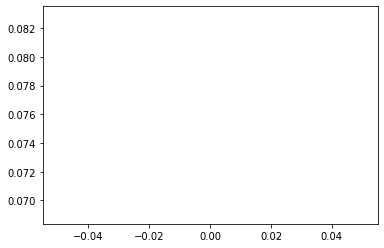

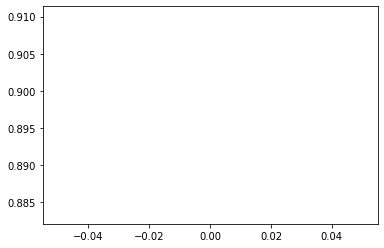

<s>아___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅡ요?</s>
<s>아ᅡ요?</s>
<s>지금 가고 싶은데 영업 중인가요?</s>________


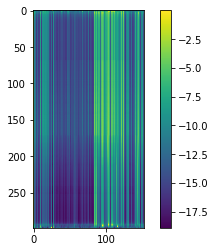

<s>아_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅡᅡ요?</s>
<s>아ᅡ요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


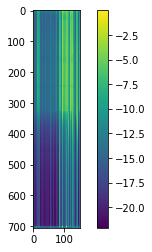

-------------------------------------------------------------------------------------------------------
09-20 13:23:43
09-20 13:28:11
Mean Train Loss: 0.06746480340095741
Train CER: 0.8806991868294339
09-20 13:28:33
Mean Evaluation Loss: 0.06246645533714619
Evaluation CER: 0.8478218231743195


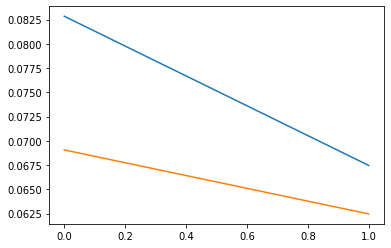

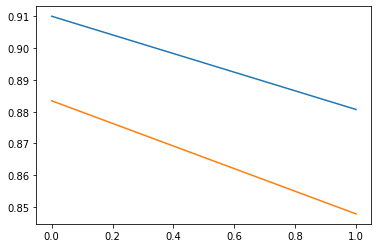

<s>아___________________________________________아______________아___이___이____아_________________________아___________________________________이___이____이___ᅵ________아___ᄋ___아________________아_______이__________________ᅡ___아______________________________________________________아____________아___ᄋ________________ᄋ_____ᄋ___이______________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아아아이이아아이이이ᅵ아ᄋ아아이ᅡ아아아ᄋᄋᄋ이나요?</s>
<s>창가 자리 예약 가능한거죠? 애기들이 있어서 룸도 예약 가능한가요? 2층으로 예약 가능해요?</s>______


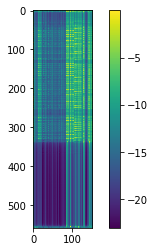

<s>아__________________________________________________________________________________이___아__아_____아__________아_____아___시______________이___________________________ᄋ____이___이___아__________아____아____아_______아____시__이___이_________이__________________ᄉ____________이____아___________________________________아____아__________ᄋ________이_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아이아아아아아시이ᄋ이이아아아아아시이이이ᄉ이아아아ᄋ이나요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


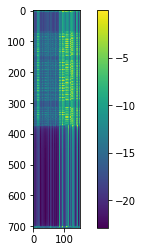

-------------------------------------------------------------------------------------------------------
09-20 13:28:33
09-20 13:33:04
Mean Train Loss: 0.06075647317652522
Train CER: 0.8488255505270779
09-20 13:33:26
Mean Evaluation Loss: 0.059096457244481725
Evaluation CER: 0.8458168980321223


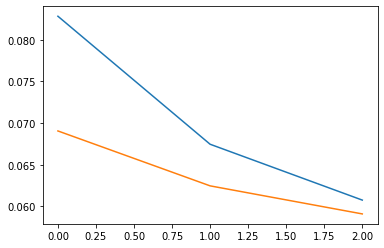

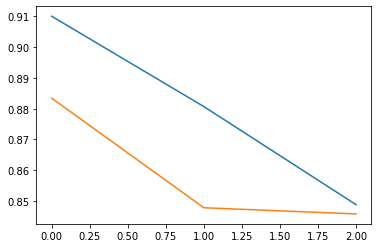

<s>아_____________________________________________________________________아______아____________________아__이___이___아___아_____이____이__시_____이___이____아___아_______아_________아___아____아_______아___아________이_____아______이______아____아____아______아____이_______ᅵ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요ᅭ?</s></s>
<s>아아아아이이아아이이시이이아아아아아아아아이아이아아아아이ᅵ나요?</s>
<s>금요일 오후 7시로 변경 해주시고 인원은 성인 4명 어린이 2명으로 변경 해주세요.</s>__


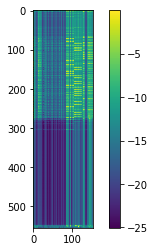

<s>아___________________________________ᅡ_____ᅡ____________ᅡ____아_________아____아____________ᅵ____아____이___아___________ᅡ_____아____아_____ᅡ_____아_____________________아________이_____ᅡ____________________아____아___________아___________________아_____아____아_____아____이______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요ᅭ?</s></s>
<s>아ᅡᅡᅡ아아아ᅵ아이아ᅡ아아ᅡ아아이ᅡ아아아아아아아이나요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


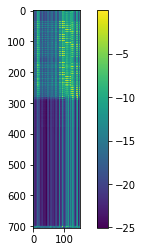

-------------------------------------------------------------------------------------------------------
09-20 13:33:27
09-20 13:37:48
Mean Train Loss: 0.05869771713731405
Train CER: 0.8460285264494625
09-20 13:38:08
Mean Evaluation Loss: 0.07779555734904074
Evaluation CER: 0.8481269204785669


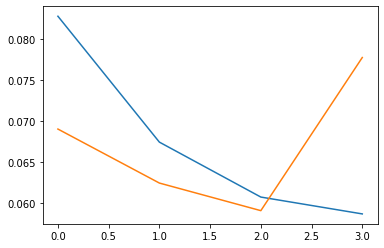

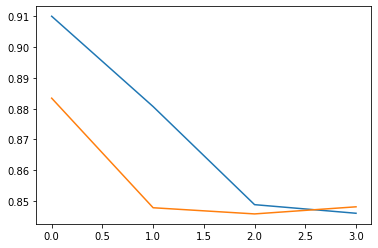

<s>아___________________________________________________이_________________아___ᅡ________아___ᅡ___아______________이___아_____________________________________이_________ᅵ______________아___아__아________아____아___아______아____________________아___ᅡ_____ᅵ_____________아_________시__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아이아ᅡ아ᅡ아이아이ᅵ아아아아아아아아ᅡᅵ아시나요?</s>
<s>애기용 숟가락 젓가락 있죠? 애기용 식기가 매장에 따로 있나요? 혹시 수유실이 있나요?</s>______

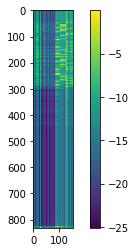

<s>아____________________________________________________________________________________________이_________________________ᅵ_______________________________________________________________________________ᅵ_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아이ᅵᅵ나요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


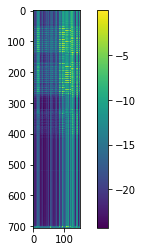

-------------------------------------------------------------------------------------------------------
09-20 13:38:09
09-20 13:42:33
Mean Train Loss: 0.05794140694646671
Train CER: 0.8354753156889821
09-20 13:42:54
Mean Evaluation Loss: 0.0961164895043678
Evaluation CER: 0.8502190162791204


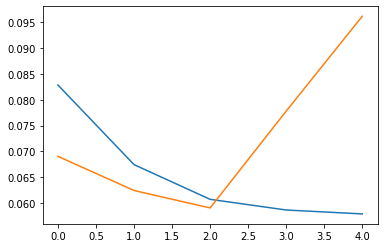

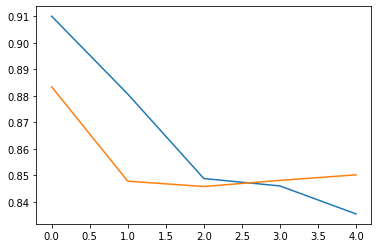

<s>ᄌ__________________________________________________________아_____아________사_____ᅡ________아____아__아______아________아_____ᅡ____아________아___이_____시________이____시_____아__이____아_____아______아__아___아____ᅡ__이___아___가_____________________ᅡ_____가_________가_______아______하______________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>ᄌ아아사ᅡ아아아아아ᅡ아아이시이시아이아아아아아ᅡ이아가ᅡ가가아하나요?</s>
<s>지난번에 식사 하고 난 후 먹지도 않았던 음식이 결재가 잘못 되었습니다. 어떻게 하실건가요?</s>


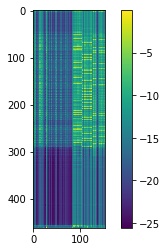

<s>아_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아나요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


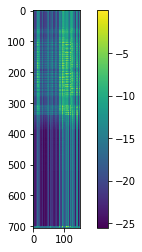

-------------------------------------------------------------------------------------------------------
09-20 13:42:55
09-20 13:47:24
Mean Train Loss: 0.05658353416186849
Train CER: 0.8241070849808777
09-20 13:47:44
Mean Evaluation Loss: 0.09541806416756203
Evaluation CER: 0.8493473096955565


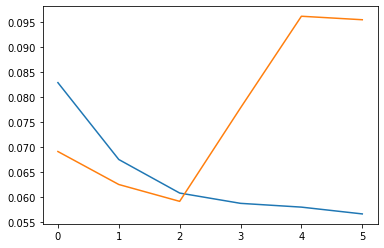

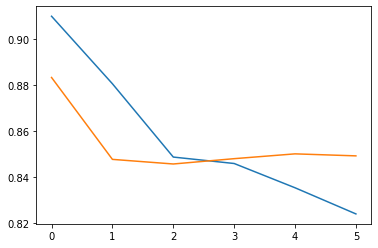

<s>아____________________________________________________이____아____________이___가_____가____아________아________ᅡ___가___아____이______________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아이아이가가아아ᅡ가아이나요?</s>
<s>안녕하세요? 예약하려고  전화했는데요.</s>


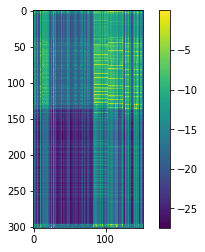

<s>아______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅵ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아ᅵ나요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


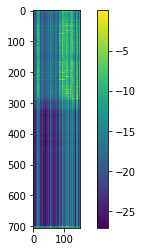

-------------------------------------------------------------------------------------------------------
09-20 13:47:45
09-20 13:52:19
Mean Train Loss: 0.05554156518364168
Train CER: 0.8166275460742047
09-20 13:52:40
Mean Evaluation Loss: 0.08599561376957378
Evaluation CER: 0.8460566173426025


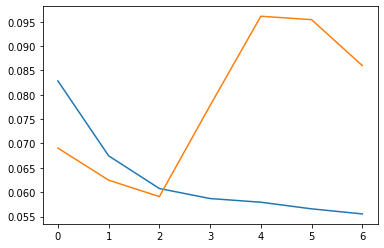

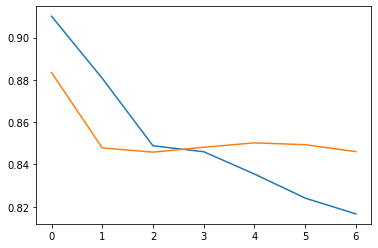

<s>여__________________________________________________________________________________가__아__으___으_______으_________시________ᅡ___________아______________________________________아_______아_____________________________________________________ᅡ_______가________________아___ᅡ____이____있_____________________________________________________________________________________________________________________________________________________나요?</s>
<s>여가아으으으시ᅡ아아아ᅡ가아ᅡ이있나요?</s>
<s>스테이크와 샐러드 음료 주문 할께요. 얼마인가요? 현대카드 있는데 할인 되나요?</s>_______


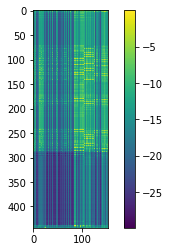

<s>여________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅡ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>여ᅡ나요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


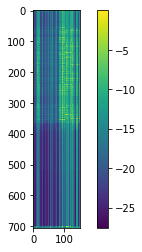

-------------------------------------------------------------------------------------------------------
09-20 13:52:41
09-20 13:57:03
Mean Train Loss: 0.055201790062031984
Train CER: 0.8157237729065762
09-20 13:57:24
Mean Evaluation Loss: 0.09985776769986501
Evaluation CER: 0.8610063852507246


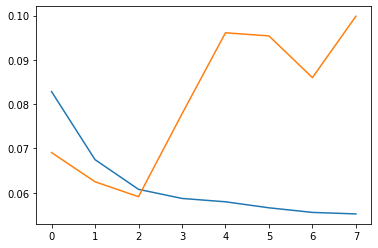

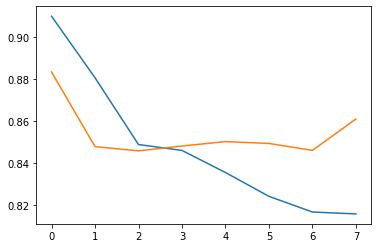

<s>아__________________________________________________________________________________________________________으___아_____으____ᅡ__가_______아___________ᅡ___가________시__시______시_____가__________________________________________________ᅡ____가_____가____아__ᄋ_____ᅳ_____여___________________________시___가___ᅵ____시____수___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

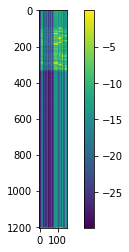

<s>아______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅡ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________네요?</s>
<s>아ᅡ네요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


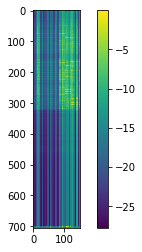

-------------------------------------------------------------------------------------------------------
09-20 13:57:24
09-20 14:01:49
Mean Train Loss: 0.05416648383616824
Train CER: 0.809718592110984
09-20 14:02:11
Mean Evaluation Loss: 0.0877113863460846
Evaluation CER: 0.9029354719201517


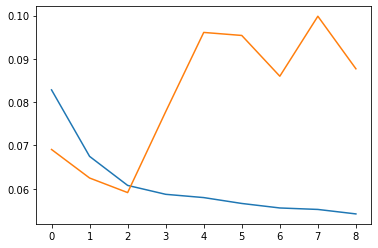

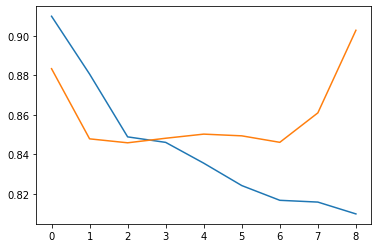

<s>지________________________________그____아____아__________이________아________________아____아__________________________ᅡᆫ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

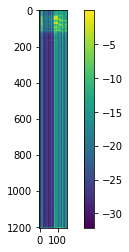

<s>아_______________________________________________________________________________________________________________________________________________ᅡ__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᅦ요?</s>
<s>아ᅡᅦ요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


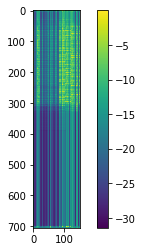

-------------------------------------------------------------------------------------------------------
09-20 14:02:11
09-20 14:06:40
Mean Train Loss: 0.05292050073741829
Train CER: 0.8007218021125673
09-20 14:07:01
Mean Evaluation Loss: 0.07719521088866009
Evaluation CER: 0.8645367969141587


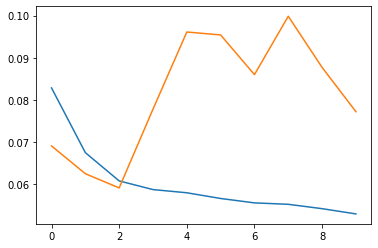

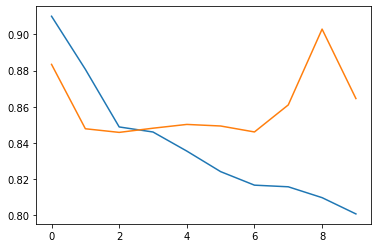

<s>애_______________________________________________________이_______시___시____아___________ᅡ__ᅡ_______지_____시______아______아_______이__이__이________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>애이시시아ᅡᅡ지시아아이이이나요?</s>
<s>네 시간은 같은시간으로 해주세요.</s>_________


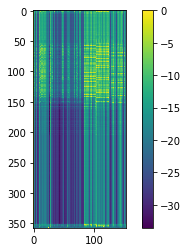

<s>지___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________가____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________시요?</s>
<s>지가시요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


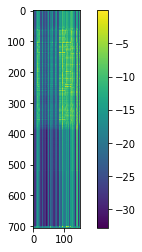

-------------------------------------------------------------------------------------------------------
09-20 14:07:01
09-20 14:11:35
Mean Train Loss: 0.052851915482930396
Train CER: 0.7971068696158558
09-20 14:11:56
Mean Evaluation Loss: 0.08973502088486304
Evaluation CER: 0.8732320700852093


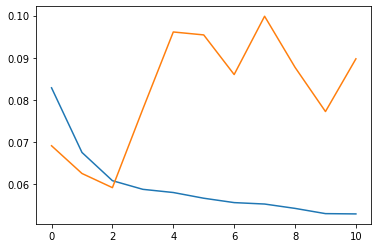

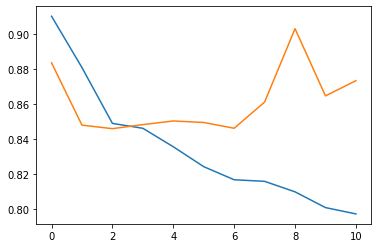

<s>아___________________________________아________으_____여__아__아_____가_________________가__아___ᄋ______시____아____시____ᅵ___사_____드_________즈__으_____오___드______가___조___ᅵ________자_______가______능_한__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

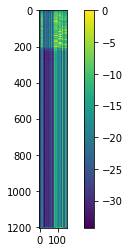

<s>아__________________________________________________________________________________ᅡ____________________________________________________________________________________________________________________ᅮ_______________________ᅡ_______________ᆸ_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________시요?</s>
<s>아ᅡᅮᅡᆸ시요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


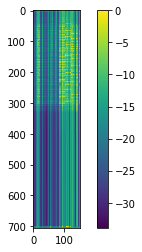

-------------------------------------------------------------------------------------------------------
09-20 14:11:57
09-20 14:16:21
Mean Train Loss: 0.05217683181148841
Train CER: 0.7912276811850553
09-20 14:16:42
Mean Evaluation Loss: 0.07356500746197416
Evaluation CER: 0.8628151764116199


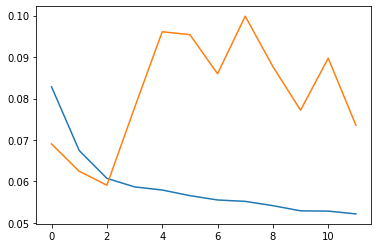

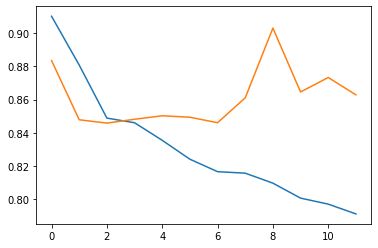

<s>이___________________________________________________아______이_____ᅡ____________그______으___ᅳ_____오__________가__가______느______________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>이아이ᅡ그으ᅳ오가가느나요?</s>
<s>예약이 가능한지 물어보려고 합니다.</s>______


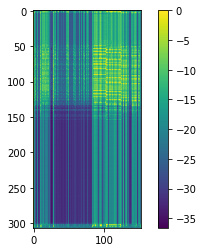

<s>아_______________________________________________________________________ᆨ____ᅡ_____________________________ᅡ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________시요?</s>
<s>악ᅡᅡ시요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


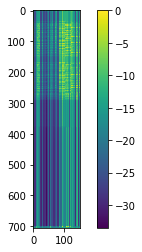

-------------------------------------------------------------------------------------------------------
09-20 14:16:42
09-20 14:21:06
Mean Train Loss: 0.051413133257860434
Train CER: 0.7847633431026576
09-20 14:21:27
Mean Evaluation Loss: 0.07504857758173983
Evaluation CER: 0.9080349554340009


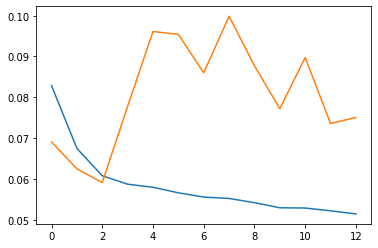

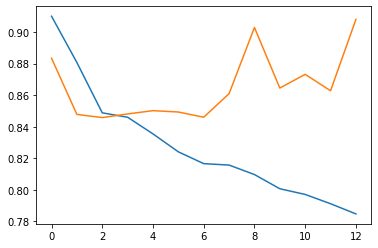

<s>오___________________________________________________________________시_______주_______________________ᅡ______ᄋ____이____아_______데____________________________________으_____으__ᄃ____________데____________________________ᄃ__________지___________________________가_____이_____________데___다______________________________데_______________________________________저____디____자____자______이__________________________________________________________________________________________________________________________________________________________________세요.</s>
<s>오시주ᅡᄋ이아데으으ᄃ데ᄃ지가이데다데저디자자이세요.</s>
<s>오지 치즈 후라이 라지 레인지랜드 립레츠 갈릭 립아이 뉴욕 스트립. 이렇게 포장해 주세요.</s>__________


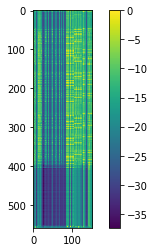

<s>아____________________________________________________________________________ᅥ___________________ᅩ_________________________ᅩ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________시요.</s>
<s>아ᅥᅩᅩ시요.</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


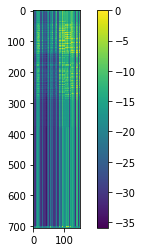

-------------------------------------------------------------------------------------------------------
09-20 14:21:28
09-20 14:25:55
Mean Train Loss: 0.05065055622170681
Train CER: 0.781013412891043
09-20 14:26:15
Mean Evaluation Loss: 0.07828795102148275
Evaluation CER: 0.8582605095124981


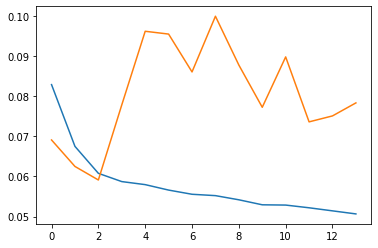

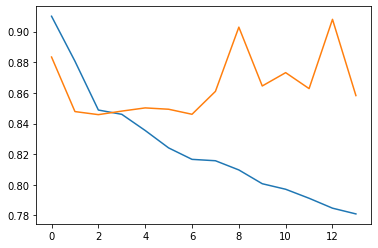

<s>오_____________________________________________________키____ᄋ__________시_____시_________________가_____하___ᅡ___이____여____아____데______________________________ᄋ_____오_____드___드______________에___________________이__________________________________________가____에___ᅳ______________으__하_____이_____________________여__어_________지_________________________이___이___가___ᅳ_____으___으________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________세요?</s>
<s>오키ᄋ시시가하ᅡ이여아데ᄋ오드드에이가에ᅳ으하이여어지이이가ᅳ으으세요?</s>
<s>오지 치즈 후라이 라지 레인지랜드 립레츠 갈릭 립아이 뉴욕 스트립. 이렇게 포자

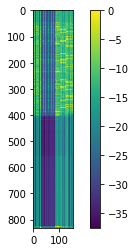

<s>아_________________________________차_______ᅡ_____________________시___ᄋ___사_______________________________________________쿠____________쿠__________________________________ᅥ__________________ᅡ_______주____________________ᅳ___구______________시_________________주____________가______ᅵ________ᅡ_____어________어_______________ᄉ_______있__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________이요?</s>
<s>아차ᅡ시ᄋ사쿠쿠ᅥᅡ주ᅳ구시주가ᅵᅡ어어ᄉ있이요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


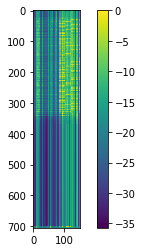

-------------------------------------------------------------------------------------------------------
09-20 14:26:16
09-20 14:30:49
Mean Train Loss: 0.05010910112089464
Train CER: 0.7748071065862808
09-20 14:31:10
Mean Evaluation Loss: 0.060846352963497385
Evaluation CER: 0.8555364264388606


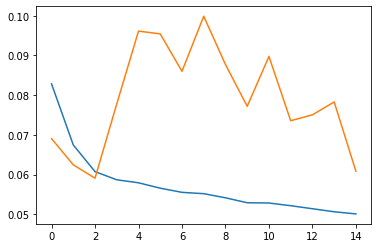

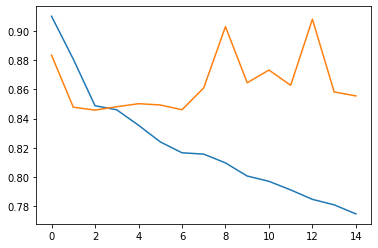

<s>여______________________________________________________________________________________________________시__________므___ᄋ________ᆾ _시_____가__아__ᄌ_____ᄋ_____ᄃ____________________________________________________________________________________네요?</s>
<s>여시므ᄋᆾ 시가아ᄌᄋᄃ네요?</s>
<s>몇시부터 몇시까지하세요?</s>________


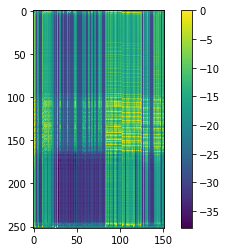

<s>아___________________________________________________________________________________________ᅡ_______ᅡ_____________________시__________ᅦ________________________________________________ᄋ________________________________어________ᅵ___이__아_____지___아____이________자_________________________________________________ᅡ____따____지___가_____________ᄋ_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________지죠?</s>
<s>아ᅡᅡ시ᅦᄋ어ᅵ이아지아이자ᅡ따지가ᄋ지죠?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


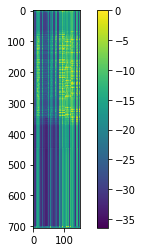

-------------------------------------------------------------------------------------------------------
09-20 14:31:11
09-20 14:35:43
Mean Train Loss: 0.0494957490004774
Train CER: 0.7703339489841761
09-20 14:36:04
Mean Evaluation Loss: 0.06376939564419669
Evaluation CER: 0.8568875716433848


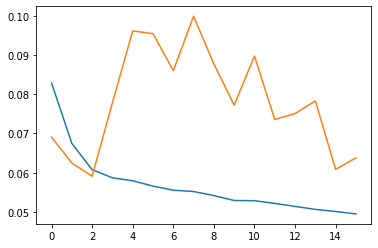

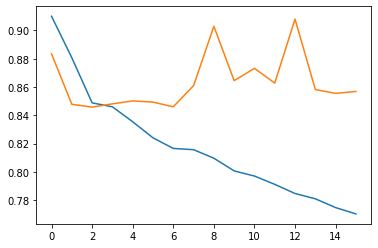

<s>아_____________________________________________치_____아___ᄋ__________시______아______아___아_____이____아______ᄋ________에____가_______________아_____이____아___________시_____이_가__아___________차___이_____________여_____가______으____ᅡ_______지___________ᅡ___이___예___아__가_____있_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>아치아ᄋ시아아아이아ᄋ에가아이아시이가아차이여가으ᅡ지ᅡ이예아가있가요?</s>
<s>아기와 함께 방문할 예정인데  앉은 자리가 혹시 나무의자인가요 아니면 쇼파로 되어져 있나요?</s>_____


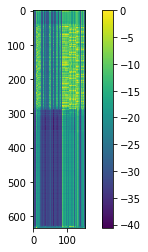

<s>지______________________________________________________________________________________________________ᅵ______________________________________오_____________________________ᅵ_____ᅵ______________________ᅵ_______________ᅩ__________________________ᅡ______________________________________________________________________________ᅥ_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________지요?</s>
<s>지ᅵ오ᅵᅵᅵᅩᅡᅥ지요?</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


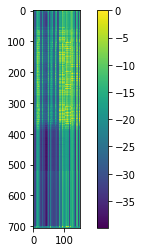

-------------------------------------------------------------------------------------------------------
09-20 14:36:05
09-20 14:40:35
Mean Train Loss: 0.04893133378866943
Train CER: 0.7649849727319772
09-20 14:40:56
Mean Evaluation Loss: 0.06398476159025297
Evaluation CER: 0.8909930917253253


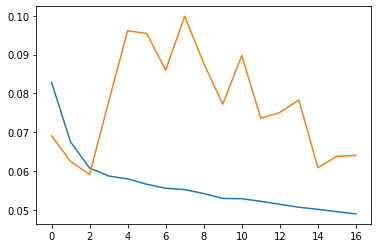

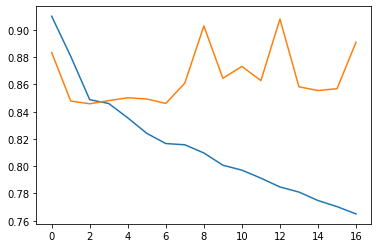

<s>에__________________________________________이____시________고________ᅩ___아___ᅡ_____________인____ᅳ__________ᅳ_______요__________________________________드___오____아_____아__아_____조____ᅳ____으____오___ᄋ_____자_____아___오___자_____가_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

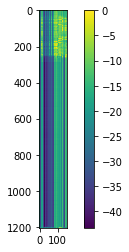

<s>주_________________________________________________________________________프_____________________________________오__________브___________________________________오_____ᅩ______ᅥ_____은__ᅵ___자_______조_____ᅩ_____ᅡ__________ᅳ______ᆫ___________주_____ᅮ_________주____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________지죠.</s>
<s>주프오브오ᅩᅥ은ᅵ자조ᅩᅡᅳᆫ주ᅮ주지죠.</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


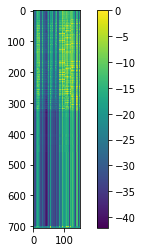

-------------------------------------------------------------------------------------------------------
09-20 14:40:57
09-20 14:45:18
Mean Train Loss: 0.04880912281444725
Train CER: 0.7635126361002896
09-20 14:45:40
Mean Evaluation Loss: 0.06314603353075009
Evaluation CER: 0.8543378298864602


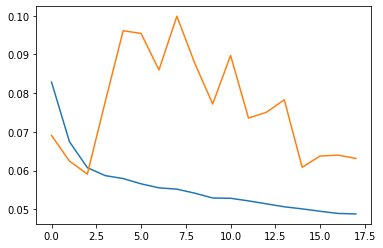

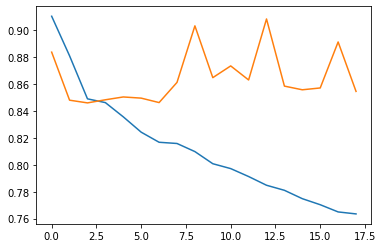

<s>예___________________________________________________이___________오___이______이____지___우____데_____ᅵ______있__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>예이오이이지우데ᅵ있나요?</s>
<s>메뉴도 미리 주문할 수 있나요?</s>__


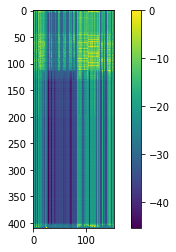

<s>오________________________________ᄋ_______________________이___아______이___아____ᄋ_____________________________________ᄋ____야__________________야______________________ᄋ_______ᅵ______________________________자_________어_________________ᅥ_____ᅥ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________세요?</s>
<s>오ᄋ이아이아ᄋᄋ야야이자어ᅥᅥ세요?</s>
<s>삼성카드 6만원이상 결제하면 3만원 현장할인되잖아요. SKT통신사 할인도 같이 할 수 있는건가요?</s>_____________________________________________________


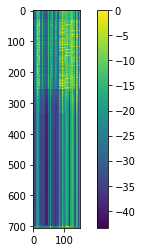

-------------------------------------------------------------------------------------------------------
09-20 14:45:41
09-20 14:50:04
Mean Train Loss: 0.047942139120851476
Train CER: 0.7577112415872825
09-20 14:50:25
Mean Evaluation Loss: 0.05970643912871334
Evaluation CER: 0.82796870573365


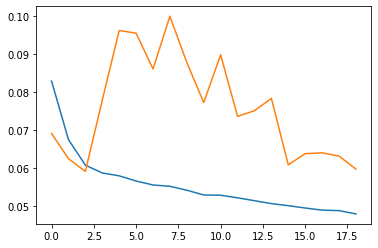

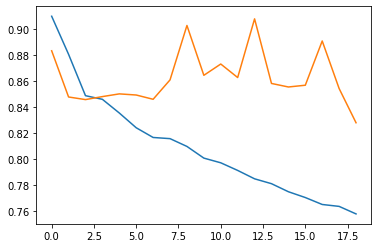

<s>아______________________________________________아_______으___에____________________________으___가_____지____에____므____ᅦ___즈_____추_____오__차______그____느____으____에___________________________________여___서______가___시_____가___아_______ᅵ__며____ᅡ___ᄒ___ᅮ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________네요?</s>
<s>아아으에으가지에므ᅦ즈추오차그느으에여서가시가아ᅵ며ᅡ후네요?</s>
<s>안녕하세요.  지금 근처인데 찾지 못하고 있는데 여기서 어떻게 가야하는지 알고 싶은데요.</s>_______


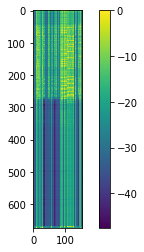

<s>재_________________________________________________________________________________________________________________야_____ᄋ_____________가_____ᄋ_____________________________이_____________________________________이____ᄋ____________________ᄋ____________ᄋ______ᄋ___________________________________________________ᄋ____ᅣ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________니됴.</s>
<s>재야ᄋ가ᄋ이이ᄋᄋᄋᄋ야니됴.</s>
<s>제가 다음주 예약을 토요일에 했는지 일요일에 했는지 헷갈려서요. 예약 확인 좀 부탁드립니다.</s>____________________________________________________________


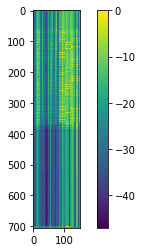

-------------------------------------------------------------------------------------------------------
09-20 14:50:26
09-20 14:54:56
Mean Train Loss: 0.05184836303337284
Train CER: 0.7892590125655783
09-20 14:55:18
Mean Evaluation Loss: 0.0610013286763352
Evaluation CER: 0.8570619129600976


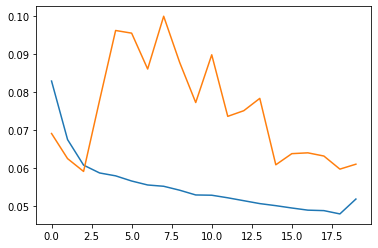

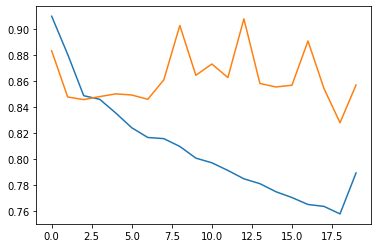

<s>아_____________________________________이____가______이_______________ᅩ__________________시________________________ᄉ_________가______ᅵ___버_____________사______시______ᅦ_____ᅦ________부_____________이___아____가_____ᅥ______뎌______________________느_____지___________________ 가____닝__하______________________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>아이가이ᅩ시ᄉ가ᅵ버사시ᅦᅦ부이아가ᅥ뎌느지 가닝하가요?</s>
<s>아 네 감사합니다! 혹시 그때 4인으로 예약했는데 2명이 더 갈 거같은데 6인으로 가능한가요?</s>__


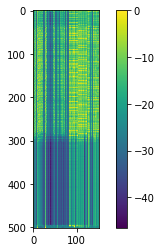

<s>아_________________________________________ᄋ________________ᄉ_____시________데_________________________ᅥ________이____ᅵ____________ᅵ______ᄌ__________________________________데______________ ___ᅥ_______시____________ᅥ__________________________________________ᅥ___시___________________이______________드____ᅥ___어____으___떠____ᄉ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>아ᄋᄉ시데ᅥ이ᅵᅵᄌ데 ᅥ시ᅥᅥ시이드ᅥ어으떠ᄉ죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


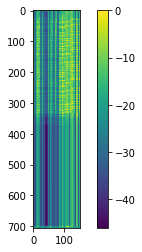

-------------------------------------------------------------------------------------------------------
09-20 14:55:18
09-20 14:59:48
Mean Train Loss: 0.04929535006555605
Train CER: 0.7701436539963875
09-20 15:00:09
Mean Evaluation Loss: 0.051695847759018636
Evaluation CER: 0.8051299932442739


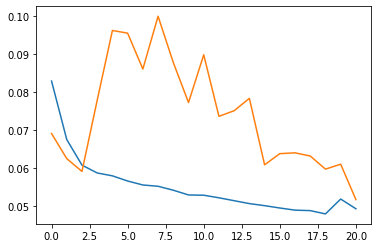

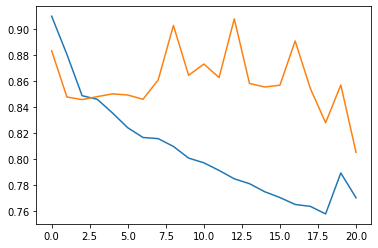

<s>이________________________________________가____이____데_______ _차____어____ᄉ___시_________가_____ᅵ______여__________지______ᄌ_ᅡ_____제____아______야______가____가____은________에___야___아._________ᄉ_______________시_______이__이____아_____자________어____이_ 가___능_낭_한__________________________________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>이가이데 차어ᄉ시가ᅵ여지자제아야가가은에야아.ᄉ시이이아자어이 가능낭한가요?</s>
<s>6월1일 5시 5명 김철수로 예약한 사림인데요 혹시 예약 변경이 가능한가요?</s>_________


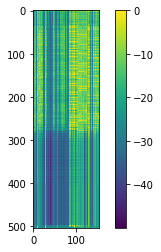

<s>아________________________________________________________이____사_______가____이___가___________시__________에____이____자______오______이___야____아___어____에_____ᅡ_________가________ᅵ____가_______지___야___ᄋ____이_______더_________이___야_____________________저_____지_______가_______는__영__ᅣ__스____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아이사가이가시에이자오이야아어에ᅡ가ᅵ가지야ᄋ이더이야저지가는영ᅣ스나요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


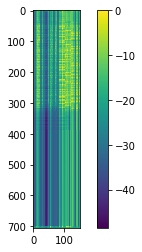

-------------------------------------------------------------------------------------------------------
09-20 15:00:10
09-20 15:04:31
Mean Train Loss: 0.04884810204629913
Train CER: 0.7693015553965051
09-20 15:04:53
Mean Evaluation Loss: 0.04986378511978625
Evaluation CER: 0.784949985834768


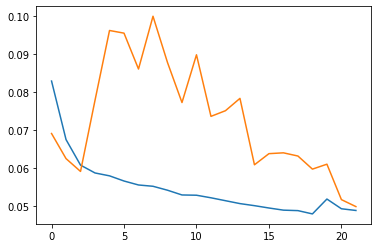

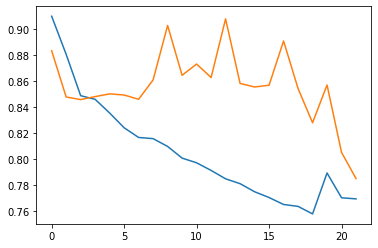

<s>아___________________________________________________________________보____ᅩ___아_____가____은____가_____이_____고_______________가_____으___지_____ᅵ___에_______ᅨ_______여__________________________________________________마_____아____느______에____ᄋ______지____가_____ᅡ__느___가_______아_____드_______즈_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________데요.</s>
<s>아보ᅩ아가은가이고가으지ᅵ에ᅨ여마아느에ᄋ지가ᅡ느가아드즈데요.</s>
<s>카톡으로 받은 할인 쿠폰 바로 쓸 수 있나요? 쿠폰 받았는데 기간 지나도 쓸 수 있

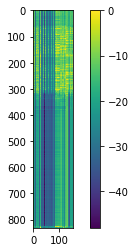

<s>아____________________________________________________ᄋ_____ᅩ_________여_____소____ᄋ______이_____오_______터_____어____이___________________ᄋ____________________________어___ᄉᄉ_______ᅡᅡ___________ᄋ_____이____________으_______지___ᄋ___가_____시_____ᅩ____거___어___하__이______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아오여소ᄋ이오터어이ᄋ어사ᄋ이으지ᄋ가시ᅩ거어하이나요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


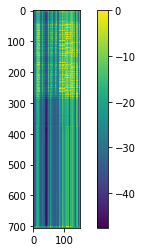

-------------------------------------------------------------------------------------------------------
09-20 15:04:54
09-20 15:09:17
Mean Train Loss: 0.047598385791961455
Train CER: 0.7605479438375042
09-20 15:09:38
Mean Evaluation Loss: 0.04723364449462664
Evaluation CER: 0.7722666550439122


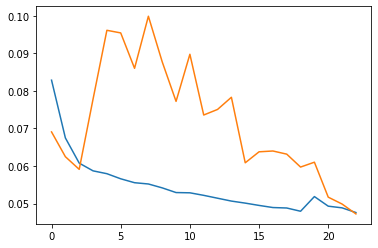

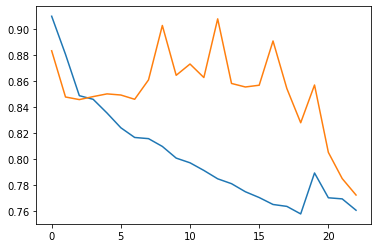

<s>오___________________________________________이___하___이___ᅡ______수_____으______ᄋ_________ᄂ____________데___에_ _가____ᄒ__________시________가___________여_______ᅡᅥ___근___며____시___여_________________ᅦ____느___ᅡ_____ᄆ_______예___이__햐_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

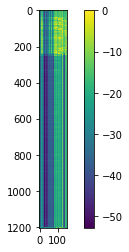

<s>오________________________________________________________ᄋ_____사______아__________아___________시___________ᅦ__________자______오______이___ᄋ_____어_________ᄋ_____가_________가_______이____마_______지___사________이_______보_________이___야_____________________보_____데______ _사__________ᄋ___아___시____어______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>오ᄋ사아아시ᅦ자오이ᄋ어ᄋ가가이마지사이보이야보데 사ᄋ아시어나요?</s>
<s>아웃백에 전화를 걸었을 때 점원이 여러분을 반갑게 맞이하며 인사합니다. 어떻게 답례하실건가요?</s>_______________________________________________________


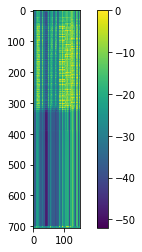

-------------------------------------------------------------------------------------------------------
09-20 15:09:39
09-20 15:14:08
Mean Train Loss: 0.05029659572617177
Train CER: 0.7791204976637673
09-20 15:14:29
Mean Evaluation Loss: 0.07528085149382929
Evaluation CER: 0.9277791095517249


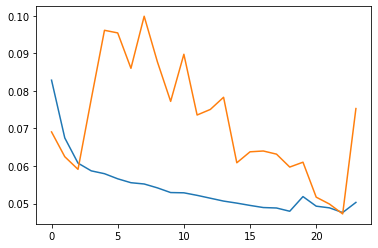

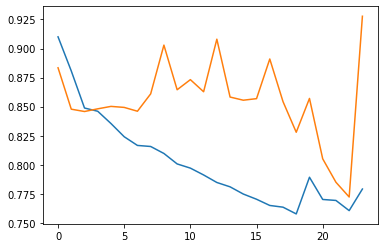

<s>오_____________________________________________ᄋ_____오____오___모____가___느___되___________________________________________________________________________________________________________________________________________________________________에요?</s>
<s>오ᄋ오오모가느되에요?</s>
<s>웰던으로 부탁드려요.</s>___________


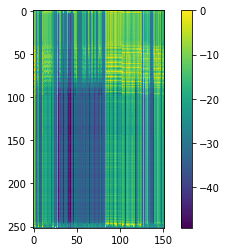

<s>아______________________________________________________________ᄉ________________________________________________________________________________________________________소_____어_______________ᅥ_______주__________거__________ᅮ__________________주________________ᅮ____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>아ᄉ소어ᅥ주거ᅮ주ᅮ죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


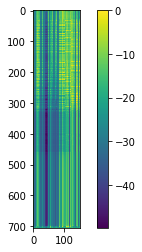

-------------------------------------------------------------------------------------------------------
09-20 15:14:30
09-20 15:19:00
Mean Train Loss: 0.049359241807669596
Train CER: 0.7653456529276914
09-20 15:19:21
Mean Evaluation Loss: 0.05547296258192757
Evaluation CER: 0.852768758036045


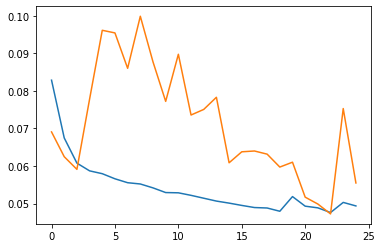

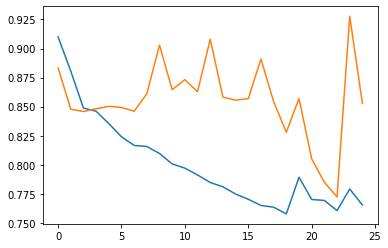

<s>애________________________________________________으___에__약_아_______시____그______데___에_______________________에____이_____________가______자________이___오____가_____ᅦ____여______가____가____드______자_____하__ᅵ___이__이___느___간______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>애으에약아시그데에에이가자이오가ᅦ여가가드자하ᅵ이이느간가요?</s>
<s>지금 예약하고 싶은데 10명 단체 할인을 받으면 몇 퍼센트 할인이 되는건가요?</s>___


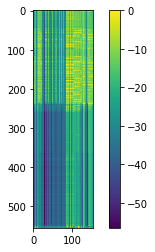

<s>이__________________________________________________________ᅮ____시____ᅵ___수_____________________ᅩ______시_______오__________으____________________________________ᅥ____소_____오_____이___이__서_______추____오____고_________푸____이___시________시___어___거____주_____구_______시_____가____어____어_____어_____수___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠.</s>
<s>이ᅮ시ᅵ수ᅩ시오으ᅥ소오이이서추오고푸이시시어거주구시가어어어수죠.</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


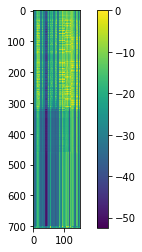

-------------------------------------------------------------------------------------------------------
09-20 15:19:22
09-20 15:23:42
Mean Train Loss: 0.04750396426125539
Train CER: 0.7568768498744896
09-20 15:24:04
Mean Evaluation Loss: 0.05697580510418883
Evaluation CER: 0.8221936496175387


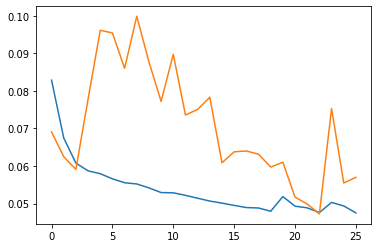

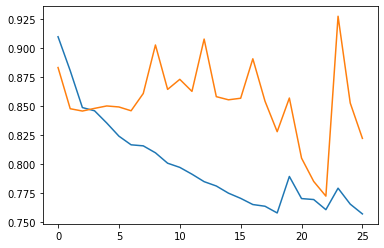

<s>아_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________아___이___ᄋ___어_____시______으______가___아____이______ᆻ___________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>아아이ᄋ어시으가아있나요?</s>
<s>8월에 영업 쉬는 날 있나요?</s>__


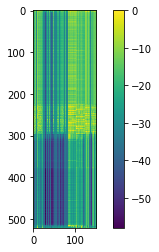

<s>주_____________________________________________________________처____________________시_______에_____ᅵ________________시______________________________________ᄎ________ᅡ____________지_____시_______가______여______이___어______________오______시______ᅩ_____주____지____ᄋ_____________________________________________________ᅵ_____치_____아_______어_____이_______ᅥ_______떠______지______ᅵ______ᆸᆸ___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________니요?</s>
<s>주처시에ᅵ시차지시가여이어오시ᅩ주지이치아어이ᅥ떠지ᅵᆸ니요?</s>
<s>근처에 버스 내리는 곳이 있나요? 아웃백이 강남역 5번 출구 쪽인가요? 위치가 골목 바깥 쪽인가요?</s>________________________________________________________


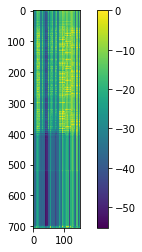

-------------------------------------------------------------------------------------------------------
09-20 15:24:05
09-20 15:28:29
Mean Train Loss: 0.048674442733125045
Train CER: 0.7670248748767489
09-20 15:28:50
Mean Evaluation Loss: 0.09033058195622488
Evaluation CER: 0.8749101052585699


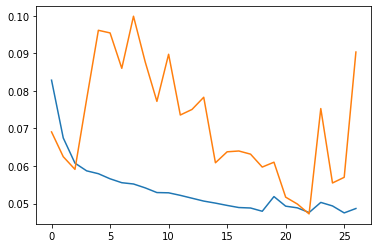

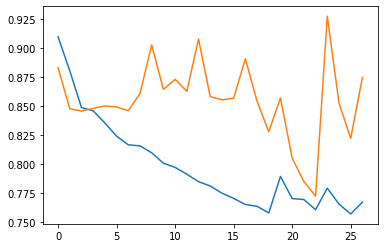

<s>ᄋ_________________________________________아_______ᅡ_______ᄋ_____아___아____아___ᄋ____오___아____으___으__________이___이_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>ᄋ아ᅡᄋ아아아ᄋ오아으으이이나요?</s>
<s>생일 쿠폰은 어떻게 받을 수 있나요?</s>____


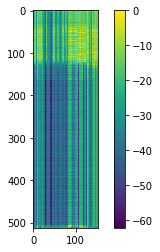

<s>여__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄉ______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>여ᄉ죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


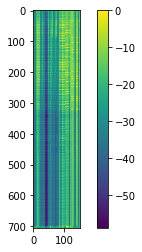

-------------------------------------------------------------------------------------------------------
09-20 15:28:51
09-20 15:33:23
Mean Train Loss: 0.05228997890789522
Train CER: 0.7867913043044391
09-20 15:33:44
Mean Evaluation Loss: 0.06484278829097116
Evaluation CER: 0.8484973957765816


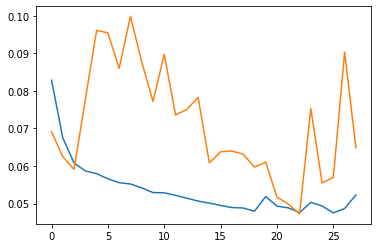

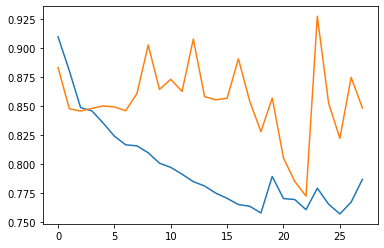

<s>지________________________________________________________으___에____오____이____가____이____ᅡᅡ____오___으___가______이______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________나요?</s>
<s>지으에오이가이ᅡ오으가이나요?</s>
<s>야유회도시락이 따로 배달 되나요?</s>


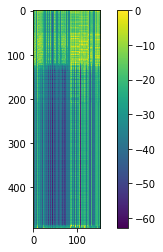

<s>아____________________________________________________오_______________여____자_____이____시_____오____ᅩ___소____오____이_____________________________________________________시__________________고_______여______오___오____ᄋ_______ᄋ___거_____지______ᆸ_________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ요?</s>
<s>아오여자이시오ᅩ소오이시고여오오ᄋᄋ거집ᄌ요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


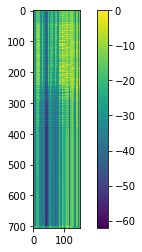

-------------------------------------------------------------------------------------------------------
09-20 15:33:45
09-20 15:38:16
Mean Train Loss: 0.04999477483485868
Train CER: 0.7749480326835971
09-20 15:38:37
Mean Evaluation Loss: 0.06584944548985829
Evaluation CER: 0.8733410334081548


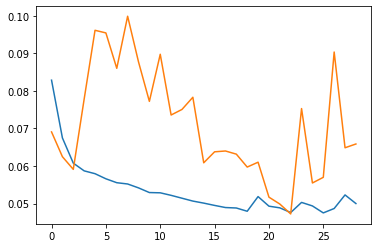

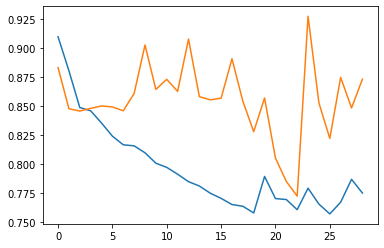

<s>아______________________________________________________________파______ᅡ____하___ᅡ_____이______오___아___아__________데____에____에_____이_____가______에_______________사_____데____포________에___이___야___ᄋ__________시____수___시____자__으____자__아__ 시______ᅵᆻ_____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

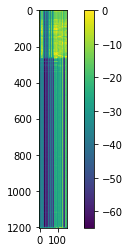

<s>에______________________________________________________________시____이_______________ᄋ__________ᅡ____________________________ᄋ___________________________________파____퍼_____어_____이____이_________수____어_____거__________서____ᄋ_____________시___어___거____서_____어_____________시_____ᄋ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>에시이아ᄋ파퍼어이이수어거서ᄋ시어거서어시ᄋ죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


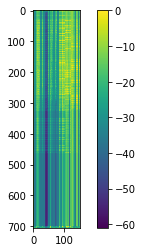

-------------------------------------------------------------------------------------------------------
09-20 15:38:38
09-20 15:43:00
Mean Train Loss: 0.05007237164010155
Train CER: 0.7757548368733412
09-20 15:43:22
Mean Evaluation Loss: 0.06537352291565614
Evaluation CER: 0.8510689301980954


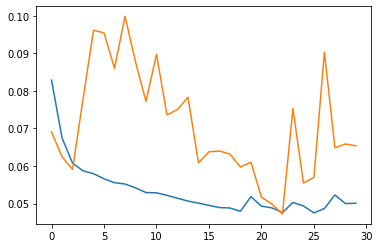

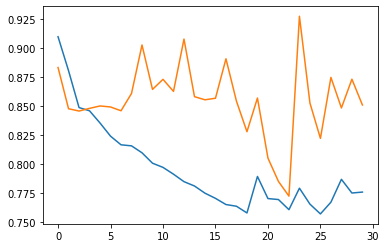

<s>며___________________________________여____셔____________여_____ᅧ___시__ᅵ__이___약________가__느__하_____ᄒ_____________________________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>며여셔여ᅧ시ᅵ이약가느하ᄒ가요?</s>
<s>내일 저녁 6시에 예약 가능할까요?</s>_________


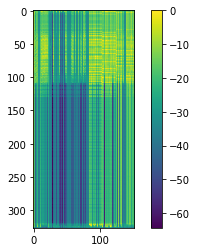

<s>에______________________________________________________________________________________________________________________ᄋ_____________________________________________________________________ᅵ_________수___________아_____________________________시__________아___________아______________ᄋ_____________________________이______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________제요?</s>
<s>에이수아시아아ᄋ이제요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


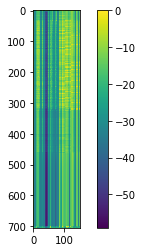

-------------------------------------------------------------------------------------------------------
09-20 15:43:23
09-20 15:47:46
Mean Train Loss: 0.050059934023383684
Train CER: 0.7728639832410594
09-20 15:48:06
Mean Evaluation Loss: 0.05616172455345189
Evaluation CER: 0.8095539041558611


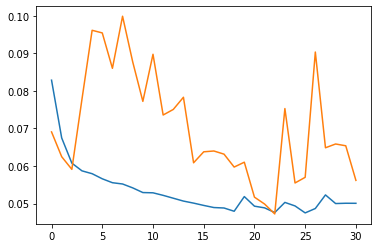

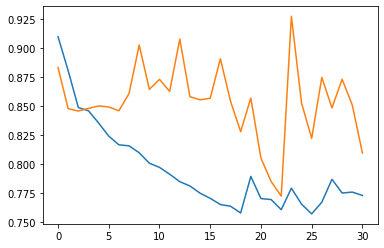

<s>이_______________________________________________________________________________________이___이___여_________가_______________________가_______하__ 가__________하____ᅡ________________ᅡ______이_____이__여__________시____________이___마___________이___므____이_____마____르___ᅵ_______마___마___아___오_____ᅩ___시__시________수___미____ᅵ_ 시____이___ᅵ_있____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

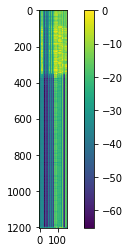

<s>아_________________________________________이_________오____ᅩ_________며_____서___어_____시______보________거____어____이__ᄋ____오____며______________________________________시______ᅡᅡ_________보____ᅵᆫ__이____ᅩ______무____이 시___이__어_____시____머____허___어___어__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________저요?</s>
<s>아이오ᅩ며서어시보거어이ᄋ오며시ᅡ보ᅵᆫ이ᅩ무이 시이어시머허어어저요?</s>
<s>안녕하세요. 여쭤볼게 있어서 전화드렸는데요. 혹시 아웃백에 외부 음식을 가지고 들어가도 되나요?</s>____________________________________________________________


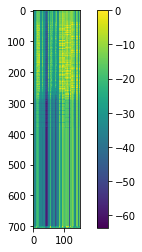

-------------------------------------------------------------------------------------------------------
09-20 15:48:07
09-20 15:52:38
Mean Train Loss: 0.04857371192920118
Train CER: 0.7645897991158302
09-20 15:53:00
Mean Evaluation Loss: 0.05379473099213271
Evaluation CER: 0.795693769477194


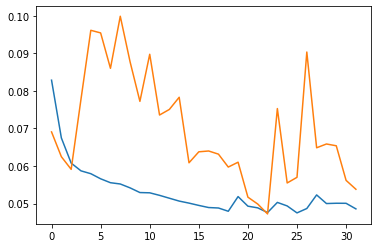

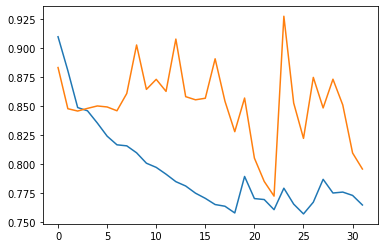

<s>오_____________________________________________________여_____지_____아_________가___사__ 가______능__한___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________가요?</s>
<s>오여지아가사 가능한가요?</s>
<s>모든 메튜 다 배달 가능한가요?</s>_


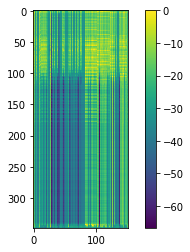

<s>아_________________________________지________________________시____ᅵ____ᅵ___소________________________ᄋ_________조__________머____이______데______________ᅥ________거________마_____메___이____시________주_____어____머___________드____이________시____________ᄆ____서_______조___가____이___이___가_____아___어___어____어___하____시___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________니요?</s>
<s>아지시ᅵᅵ소ᄋ조머이데ᅥ거마메이시주어머드이시ᄆ서조가이이가아어어어하시니요?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


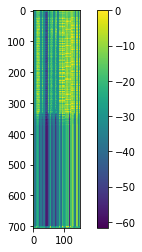

-------------------------------------------------------------------------------------------------------
09-20 15:53:00
09-20 15:57:30
Mean Train Loss: 0.04870835450828282
Train CER: 0.7634527562863869
09-20 15:57:51
Mean Evaluation Loss: 0.05061985513811665
Evaluation CER: 0.7841436572449714


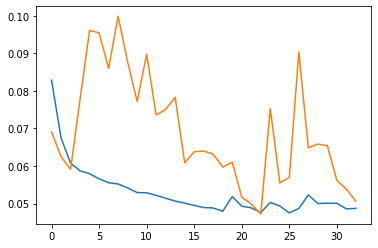

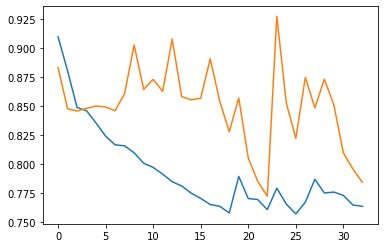

<s>이_________________________________________________지__________ᄉ____ᅡ____ᅡ_________가___가__ᅡ__아____이_______자________________________그______시_____________시___이______가______ᅳ___가____아____가____ᄋ____은___마___에________________________가____시__ᅵ___우___주_________시___인__있______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

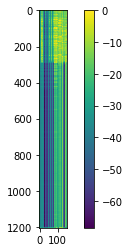

<s>아_________________________ᄋ_______주______가________________시___시________조____오________ᅡ_________아________조______ᆫ___그____이______조___에________가________고____ᅩ___그_____메____이____저________주___으_____아______으___스_____이_______시_____오_____도___ᄉ________지____가____이_______가_____그___가___가____느__아______시__________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________ᄌᄌ죠?</s>
<s>아ᄋ주가시시조오ᅡ아존그이조에가고ᅩ그메이저주으아으스이시오도ᄉ지가이가그가가느아시죠?</s>
<s>그럼 제가 sk텔레콤 골드 등급인데 쿠폰 금액 이상 주문건에 대해 15%할인 가능하다는 말씀이죠?</s>__________________________________________________________


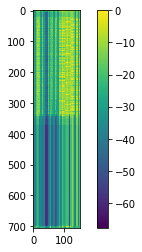

-------------------------------------------------------------------------------------------------------
09-20 15:57:52


In [ ]:
EPOCH = 12 * 6     
           
# net = Mel2SeqNet(80, 512, 256)

net = Mel2SeqNet(n_mels, 1024, 512, len(unicode_jamo_list), device)

net_optimizer = optim.Adam(net.parameters(), lr=0.001)

ctc_loss = nn.CTCLoss().to(device)

keyword = 'NSML_mel_256'

train_loss_history = list()
eval_loss_history = list()

train_cer_history = list()
eval_cer_history = list()

try:
    train_cer_history = list(np.load('model_saved/train_cer_history{}.npy'.format(keyword)))
    eval_cer_history = list(np.load('model_saved/eval_cer_history{}.npy'.format(keyword)))
except:
    print("No CER Record")

try:
    load(net, net_optimizer, 'model_saved/{}'.format(keyword))
    train_loss_history = list(np.load('model_saved/train_loss_history_{}.npy'.format(keyword)))
    eval_loss_history = list(np.load('model_saved/eval_loss_history_{}.npy'.format(keyword)))
except:
    print("Loading {} Error".format(keyword))


for epoch in range(EPOCH):

    print((datetime.now().strftime('%m-%d %H:%M:%S')))

    preloader_train.initialize_batch(num_thread)
    loss_list_train = list()

    total_dist = 0
    total_length = 0
#     count = 0
    while preloader_train.end_flag == False:
        batch = preloader_train.get_batch()
        # logger.info("Got Batch")
        if batch != None:
            tensor_input, ground_truth, loss_mask, length_list, lev_truth_list = batch
            pred_tensor, loss = train(net, net_optimizer, ctc_loss, tensor_input.to(device),
                                      ground_truth.to(device), loss_mask.to(device), length_list.to(device))
            loss_list_train.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
#             print("Loss: {}".format(loss))
#             count += 1
#             print("Train {}/{}".format(count, int(np.ceil(len(wav_path_list_train)/batch_size))))
#             # logger.info("Training")

    train_cer = total_dist / total_length
    train_loss = np.mean(np.asarray(loss_list_train))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Train Loss: {}".format(train_loss))
    print("Train CER: {}".format(train_cer))
    train_loss_history.append(train_loss)
    train_cer_history.append(train_cer)
    
    preloader_eval.initialize_batch(num_thread)
    loss_list_eval = list()

    total_dist = 0
    total_length = 0
    
    while preloader_eval.end_flag == False:
        batch = preloader_eval.get_batch()
        if batch != None:
            tensor_input, ground_truth_, loss_mask, length_list, lev_truth_list_ = batch
            pred_tensor_, loss = evaluate(net, ctc_loss, tensor_input.to(device), ground_truth_.to(device),
                                          loss_mask.to(device), length_list.to(device))
            loss_list_eval.append(loss)
            
            lev_pred_list = Decode_Prediction(pred_tensor_, tokenizer, char2index)
            lev_str_list = lev_num_to_lev_string(lev_truth_list_, index2char)
            dist, length = char_distance_list(lev_str_list, lev_pred_list)
            total_dist += dist
            total_length += length
            
    eval_cer = total_dist / total_length
    eval_loss = np.mean(np.asarray(loss_list_eval))
    print((datetime.now().strftime('%m-%d %H:%M:%S')))
    print("Mean Evaluation Loss: {}".format(eval_loss))
    print("Evaluation CER: {}".format(eval_cer))
    eval_loss_history.append(eval_loss)
    eval_cer_history.append(eval_cer)
    
    #####
    
    save(net, net_optimizer, 'model_saved/{}'.format(keyword))
    np.save('model_saved/train_loss_history_{}'.format(keyword), train_loss_history)
    np.save('model_saved/eval_loss_history_{}'.format(keyword), eval_loss_history)
    np.save('model_saved/train_cer_history{}'.format(keyword), train_cer_history)
    np.save('model_saved/eval_cer_history{}'.format(keyword), eval_cer_history)
            
    #####    
    
    plt.figure()
    plt.plot(train_loss_history)
    plt.plot(eval_loss_history)
    plt.show()
    
    plt.figure()
    plt.plot(train_cer_history)
    plt.plot(eval_cer_history)
    plt.show()

    # index is the position of the max probility of the first batch
    # Shape of the pred_tensor: (T, B, 75)
    # Shape of the index: (T)
    _, index = pred_tensor[:, 0, :].max(-1)

    # Change index numbers to character
    sentence = tokenizer.num2word(index.view(-1))

    # Change list to string
    print(''.join(sentence))

    # Remove "blank" and overlapping characters
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))

    true_sentence = tokenizer.num2word(ground_truth[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    # Plot image
    # detach().cpu().numpy() transforms a tensor on gpu into a numpy matrix
    plt.figure()
    plt.imshow(pred_tensor[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()

    _, index = pred_tensor_[:, 0, :].max(-1)

    sentence = tokenizer.num2word(index.view(-1))
    print(''.join(sentence))
    index_ = Decode_CTC_Prediction(index)
    sentence_ = tokenizer.num2word(index_)
    print(''.join(sentence_))
    true_sentence = tokenizer.num2word(ground_truth_[0, :].detach().numpy().astype(int))
    print(''.join(true_sentence))

    plt.figure()
    plt.imshow(pred_tensor_[:, 0, :].detach().cpu().numpy())
    plt.colorbar()
    plt.show()
        
    print("-------------------------------------------------------------------------------------------------------")
    